从LOF过来的文件。LOF+Grubbs+BN
---

In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from theano import shared
import pandas as pd
from matplotlib import gridspec
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import scale
from mpl_toolkits.mplot3d import Axes3D
# import sklearn as sl
# from sklearn.neighbors import LocalOutlierFactor

D:\Softwares\Python\Python_Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# plt.style.use('default')
font1 ={'family': 'times', 'weight':'light', 'size': 12}  
# font2 ={'family': 'Arial', 'weight':'normal', 'size': 12}  
def Plot_XZ(elec_year, elec_faults):
# 画出原始图
    Company_names = ['Xizang', 'Xinjiang', 'Heilongjiang']
    j= 0
    plt.figure(figsize=(4, 3), facecolor='w')
    ax = plt.subplot(1, 1, 1)
    for jx in range(11):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=3, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016', '2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[0]], loc='upper left', frameon=False, fontsize='small')

    plt.show()
    return 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


D:\Softwares\Python\Python_Anaconda\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


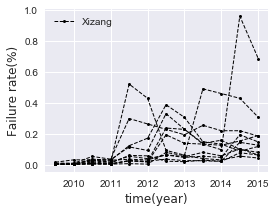

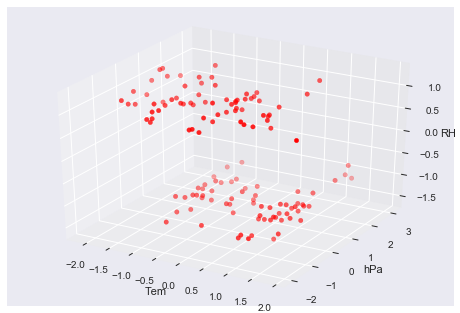

In [3]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储

elec_data = pd.read_csv('XZnozero_12_longB.csv')
elec_dataA = pd.read_csv('XZnozero_12.csv')
# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中




# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 2, size=[len(elec_data.Year.values), 4])
SNR_Tem = np.random.normal(0, 0.5, size=[len(elec_data.Year.values), 1])
# #特征因素分析

elec_tem = elec_data.Tem.values + SNR_Tem[:, 0] # 观测温度值x2
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 1]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 2] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 3] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)

# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)

elec_data.Fault.values[118] =210
elec_data.Fault.values[119] =150

elec_dataA.Fault.values[202] =210
elec_dataA.Fault.values[203] =150
elec_dataA.Fault.values[218] =165
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 100 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)

print(elec_faults)
elec_faultsA = 100 * (elec_dataA.Fault.values / elec_dataA.Nums.values)


# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*12:(i+1)*12] for i in np.arange(11)])
elec_year2 = np.array([elec_year[i*12:(i+1)*12] for i in np.arange(11)])
elec_faultsAC = np.array([elec_faultsA[i*12:(i+1)*12] for i in np.arange(25)])
elec_faults_A = elec_faultsAC[:7] #分别取ABC省的原始数据，用于计算LOF中的Grubbs
elec_faults_C = elec_faultsAC[18:]
# print(elec_faults_A)
# print(elec_faults_C)
# 画图
Plot_XZ(elec_year2, elec_faults2)

# plt.figure(figsize=(4, 3), facecolor='w')
ax = plt.subplot(111, projection='3d')
ax.scatter(elec_tem1, elec_hPa1, elec_RH1, c='r')
ax.set_zlabel('RH')  # 坐标轴
ax.set_ylabel('hPa')
ax.set_xlabel('Tem')
plt.show()

In [4]:
from lof import *
# Instane2_A, Instane2_B, Instane2_C：为故障+时间
# Instane5_A, Instane5_B, Instane5_C：为故障+时间+温度+压强+湿度
# 矩阵乘以权重需要将list转换为Numpy: np.array(Instane),才能调用切片
# 权重矩阵Weight为：
Weight = np.array([1.0, 0.7311650684715499, 0.4273930180878881 ,0.35659903015510097 ,0.6406373000946504])
Weight_sqrt = np.sqrt(Weight) #取平方根作为LOF权重
# 注意，一下数据全部已经和权重相乘了
Instane2_A =[
[ -0.8026384567926785 , -1.3623635361318311 ] ,
[ -0.8026384567926785 , -1.1146610750169528 ] ,
[ -0.8026384567926785 , -0.8669586139020743 ] ,
[ -0.8026384567926785 , -0.6192561527871959 ] ,
[ -0.7108600304388067 , -0.37155369167231755 ] ,
[ -0.7475714009803555 , -0.12385123055743918 ] ,
[ -0.453880436647966 , 0.12385123055743918 ] ,
[ -0.03169967542015602 , 0.37155369167231755 ] ,
[ 0.40883677107842814 , 0.6192561527871959 ] ,
[ 0.7392391059523664 , 0.8669586139020743 ] ,
[ -0.2703235839402225 , 1.1146610750169528 ] ,
[ 0.041723065662941324 , 1.3623635361318311 ] ,
[ -0.44358896457146485 , -1.3623635361318311 ] ,
[ -0.44358896457146485 , -1.1146610750169528 ] ,
[ -0.44358896457146485 , -0.8669586139020743 ] ,
[ -0.06618378707947692 , -0.6192561527871959 ] ,
[ -0.44358896457146485 , -0.37155369167231755 ] ,
[ -0.06618378707947692 , -0.12385123055743918 ] ,
[ 0.311221390412511 , 0.12385123055743918 ] ,
[ -0.06618378707947692 , 0.37155369167231755 ] ,
[ 1.443436922888475 , 0.6192561527871959 ] ,
[ 1.066031745396487 , 0.8669586139020743 ] ,
[ 1.443436922888475 , 1.1146610750169528 ] ,
[ 2.1982472778724507 , 1.3623635361318311 ] ,
[ -0.8101188301005176 , -1.3623635361318311 ] ,
[ -0.8101188301005176 , -1.1146610750169528 ] ,
[ -0.7992435181375823 , -0.8669586139020743 ] ,
[ -0.8101188301005176 , -0.6192561527871959 ] ,
[ -0.6578644626194238 , -0.37155369167231755 ] ,
[ -0.6904903985082297 , -0.12385123055743918 ] ,
[ -0.33160510373136576 , 0.12385123055743918 ] ,
[ -0.3751063515831068 , 0.37155369167231755 ] ,
[ -0.7013657104711649 , 0.6192561527871959 ] ,
[ -0.7122410224341001 , 0.8669586139020743 ] ,
[ -0.3207297917684304 , 1.1146610750169528 ] ,
[ -0.16847542428733672 , 1.3623635361318311 ] ,
[ -0.6834314801440002 , -1.3623635361318311 ] ,
[ -0.6834314801440002 , -1.1146610750169528 ] ,
[ -0.4633312210728759 , -0.8669586139020743 ] ,
[ -0.4908437534567664 , -0.6192561527871959 ] ,
[ -0.6008938829923285 , -0.37155369167231755 ] ,
[ -0.6559189477601096 , -0.12385123055743918 ] ,
[ -0.4908437534567664 , 0.12385123055743918 ] ,
[ -0.7109440125278906 , 0.37155369167231755 ] ,
[ -0.4633312210728759 , 0.6192561527871959 ] ,
[ -0.43581868868898527 , 0.8669586139020743 ] ,
[ 0.5271199447471835 , 1.1146610750169528 ] ,
[ 0.5821450095149646 , 1.3623635361318311 ] ,
[ -0.7492931584222882 , -1.3623635361318311 ] ,
[ -0.6775921747811235 , -1.1146610750169528 ] ,
[ -0.7492931584222882 , -0.8669586139020743 ] ,
[ -0.7492931584222882 , -0.6192561527871959 ] ,
[ -0.31908725657530035 , -0.37155369167231755 ] ,
[ -0.46248922385762964 , -0.12385123055743918 ] ,
[ 0.32622159619518154 , 0.12385123055743918 ] ,
[ 0.18281962891285214 , 0.37155369167231755 ] ,
[ -0.10398430565180646 , 0.6192561527871959 ] ,
[ -0.03228332201064176 , 0.8669586139020743 ] ,
[ -0.46248922385762964 , 1.1146610750169528 ] ,
[ -0.46248922385762964 , 1.3623635361318311 ] ,
[ -0.6597790617764374 , -1.3623635361318311 ] ,
[ -0.6597790617764374 , -1.1146610750169528 ] ,
[ -0.6597790617764374 , -0.8669586139020743 ] ,
[ -0.17613382091539118 , -0.6192561527871959 ] ,
[ -0.6597790617764374 , -0.37155369167231755 ] ,
[ -0.49856398148942194 , -0.12385123055743918 ] ,
[ -0.49856398148942194 , 0.12385123055743918 ] ,
[ -0.17613382091539118 , 0.37155369167231755 ] ,
[ 1.9196622228158093 , 0.6192561527871959 ] ,
[ 2.4033074636768554 , 0.8669586139020743 ] ,
[ 2.24209238338984 , 1.1146610750169528 ] ,
[ 2.4033074636768554 , 1.3623635361318311 ] ,
[ -0.7554895397246111 , -1.3623635361318311 ] ,
[ -0.7554895397246111 , -1.1146610750169528 ] ,
[ -0.6899849373857693 , -0.8669586139020743 ] ,
[ -0.6244803350469275 , -0.6192561527871959 ] ,
[ 0.030565688341490274 , -0.37155369167231755 ] ,
[ -0.10044351633619333 , -0.12385123055743918 ] ,
[ 2.061208360845585 , 0.12385123055743918 ] ,
[ 2.454235974878636 , 0.37155369167231755 ] ,
[ 2.8472635889116864 , 0.6192561527871959 ] ,
[ 2.454235974878636 , 0.8669586139020743 ] ,
[ 1.86469455382906 , 1.1146610750169528 ] ,
[ 1.9957037585067434 , 1.3623635361318311 ]
]


Instane2_B =[
[ -0.6960818063139069 , -1.3623635361318311 ] ,
[ -0.6960818063139069 , -1.1146610750169528 ] ,
[ -0.4623108127945375 , -0.8669586139020743 ] ,
[ -0.5114223660549093 , -0.6192561527871959 ] ,
[ -0.46820419918578204 , -0.37155369167231755 ] ,
[ -0.4957066690115903 , -0.12385123055743918 ] ,
[ -0.26782906188346534 , 0.12385123055743918 ] ,
[ -0.348372009230475 , 0.37155369167231755 ] ,
[ -0.1597836447106476 , 0.6192561527871959 ] ,
[ -0.3149761530134223 , 0.8669586139020743 ] ,
[ -0.0006622121470431206 , 1.1146610750169528 ] ,
[ -0.2756869104051249 , 1.3623635361318311 ] ,
[ -0.698858413068419 , -1.3623635361318311 ] ,
[ -0.698858413068419 , -1.1146610750169528 ] ,
[ -0.6628177489565101 , -0.8669586139020743 ] ,
[ -0.6718279149844872 , -0.6192561527871959 ] ,
[ -0.5276652585368518 , -0.37155369167231755 ] ,
[ -0.5546957566207835 , -0.12385123055743918 ] ,
[ -0.4645940963410113 , 0.12385123055743918 ] ,
[ -0.5276652585368518 , 0.37155369167231755 ] ,
[ -0.5366754245648291 , 0.6192561527871959 ] ,
[ -0.5637059226487607 , 0.8669586139020743 ] ,
[ -0.17626878344574035 , 1.1146610750169528 ] ,
[ -0.27538060975348966 , 1.3623635361318311 ] ,
[ -0.6861083642793375 , -1.3623635361318311 ] ,
[ -0.6861083642793375 , -1.1146610750169528 ] ,
[ -0.599067505011103 , -0.8669586139020743 ] ,
[ -0.6425879346452202 , -0.6192561527871959 ] ,
[ -0.294424497572282 , -0.37155369167231755 ] ,
[ -0.3161847123893406 , -0.12385123055743918 ] ,
[ -0.5555470753769857 , 0.12385123055743918 ] ,
[ -0.5773072901940444 , 0.37155369167231755 ] ,
[ -0.5120266457428684 , 0.6192561527871959 ] ,
[ -0.5555470753769857 , 0.8669586139020743 ] ,
[ 0.2931013024883013 , 1.1146610750169528 ] ,
[ 0.16254001358594958 , 1.3623635361318311 ] ,
[ -0.6469540803928013 , -1.3623635361318311 ] ,
[ -0.6469540803928013 , -1.1146610750169528 ] ,
[ -0.3423815868748274 , -0.8669586139020743 ] ,
[ -0.46421058428201695 , -0.6192561527871959 ] ,
[ 1.3632243768258268 , -0.37155369167231755 ] ,
[ 1.1195663820114479 , -0.12385123055743918 ] ,
[ 0.8759083871970685 , 0.12385123055743918 ] ,
[ 0.6322503923826894 , 0.37155369167231755 ] ,
[ 1.0586518833078529 , 0.6192561527871959 ] ,
[ 0.8149938884934739 , 0.8669586139020743 ] ,
[ 0.8149938884934739 , 1.1146610750169528 ] ,
[ 0.5713358936790948 , 1.3623635361318311 ] ,
[ -0.6542266119363125 , -1.3623635361318311 ] ,
[ -0.6542266119363125 , -1.1146610750169528 ] ,
[ -0.5469426776161451 , -0.8669586139020743 ] ,
[ -0.6005846447762287 , -0.6192561527871959 ] ,
[ -0.3323748089758102 , -0.37155369167231755 ] ,
[ -0.43965874329597765 , -0.12385123055743918 ] ,
[ -0.27873284181572644 , 0.12385123055743918 ] ,
[ -0.3860167761358939 , 0.37155369167231755 ] ,
[ -0.3323748089758102 , 0.6192561527871959 ] ,
[ -0.3860167761358939 , 0.8669586139020743 ] ,
[ 0.6331805999056965 , 1.1146610750169528 ] ,
[ 0.3113287969451945 , 1.3623635361318311 ] ,
[ -0.6014057371864551 , -1.3623635361318311 ] ,
[ -0.49494289527651397 , -1.1146610750169528 ] ,
[ -0.49494289527651397 , -0.8669586139020743 ] ,
[ -0.6014057371864551 , -0.6192561527871959 ] ,
[ 2.911868045841602 , -0.37155369167231755 ] ,
[ 2.2730909943819557 , -0.12385123055743918 ] ,
[ -0.06909152763674935 , 0.12385123055743918 ] ,
[ -0.28201721145663167 , 0.37155369167231755 ] ,
[ 2.6989423620217203 , 0.6192561527871959 ] ,
[ 2.486016678201838 , 0.8669586139020743 ] ,
[ 2.2730909943819557 , 1.1146610750169528 ] ,
[ 1.4213882591024263 , 1.3623635361318311 ] ,
[ -0.6868513927972499 , -1.3623635361318311 ] ,
[ -0.6868513927972499 , -1.1146610750169528 ] ,
[ -0.6868513927972499 , -0.8669586139020743 ] ,
[ -0.6868513927972499 , -0.6192561527871959 ] ,
[ -0.6658342064981038 , -0.37155369167231755 ] ,
[ -0.6868513927972499 , -0.12385123055743918 ] ,
[ -0.16142173531859474 , 0.12385123055743918 ] ,
[ -0.30854203941261826 , 0.37155369167231755 ] ,
[ -0.43464515720749547 , 0.6192561527871959 ] ,
[ -0.4976967161049341 , 0.8669586139020743 ] ,
[ -0.3295592257117645 , 1.1146610750169528 ] ,
[ -0.4136279709083493 , 1.3623635361318311 ] ,
[ -0.6991670522019792 , -1.3623635361318311 ] ,
[ -0.6991670522019792 , -1.1146610750169528 ] ,
[ -0.6643609446243112 , -0.8669586139020743 ] ,
[ -0.6904655253075622 , -0.6192561527871959 ] ,
[ -0.5338380412080562 , -0.37155369167231755 ] ,
[ -0.5947487294689752 , -0.12385123055743918 ] ,
[ 0.6321665626438221 , 0.12385123055743918 ] ,
[ 0.24929937928947413 , 0.37155369167231755 ] ,
[ 0.21449327171180613 , 0.6192561527871959 ] ,
[ 0.16228411034530396 , 0.8669586139020743 ] ,
[ 0.35371770202247804 , 1.1146610750169528 ] ,
[ 0.5973604550661541 , 1.3623635361318311 ] ,
[ -0.6724568512720672 , -1.3623635361318311 ] ,
[ -0.6901631659100905 , -1.1146610750169528 ] ,
[ -0.49540902929566955 , -0.8669586139020743 ] ,
[ -0.5131189492586948 , -0.6192561527871959 ] ,
[ 0.14192635593101768 , -0.37155369167231755 ] ,
[ 0.47827332522926475 , -0.12385123055743918 ] ,
[ 1.983011725883295 , 0.12385123055743918 ] ,
[ 1.4164565384611247 , 0.37155369167231755 ] ,
[ 0.3188624282709603 , 0.6192561527871959 ] ,
[ 0.2126254475834431 , 0.8669586139020743 ] ,
[ -0.10602241777297297 , 1.1146610750169528 ] ,
[ 0.10637315162133193 , 1.3623635361318311 ] ,
[ -0.6760791122013075 , -1.3623635361318311 ] ,
[ -0.6760791122013075 , -1.1146610750169528 ] ,
[ -0.517131777725864 , -0.8669586139020743 ] ,
[ -0.4853423108307754 , -0.6192561527871959 ] ,
[ 0.086868093280821 , -0.37155369167231755 ] ,
[ -0.0720792411946224 , -0.12385123055743918 ] ,
[ 1.5809730373499893 , 0.12385123055743918 ] ,
[ 0.8816047656580382 , 0.37155369167231755 ] ,
[ 0.2140259608611759 , 0.6192561527871959 ] ,
[ -0.040289774299533704 , 0.8669586139020743 ] ,
[ 5.967919468872228 , 1.1146610750169528 ] ,
[ 4.060551455166908 , 1.3623635361318311 ] ,
[ -0.6969149632374163 , -1.3623635361318311 ] ,
[ -0.6859613473784365 , -1.1146610750169528 ] ,
[ -0.6531004998014968 , -0.8669586139020743 ] ,
[ -0.6750077315194566 , -0.6192561527871959 ] ,
[ -0.543564341211698 , -0.37155369167231755 ] ,
[ -0.5764251887886376 , -0.12385123055743918 ] ,
[ 0.9351737997505859 , 0.12385123055743918 ] ,
[ 0.8749289125261964 , 0.37155369167231755 ] ,
[ 0.2505728085643434 , 0.6192561527871959 ] ,
[ 0.38749300680159166 , 0.8669586139020743 ] ,
[ -0.02326758791015369 , 1.1146610750169528 ] ,
[ -0.16018778614740228 , 1.3623635361318311 ] ,
]


Instane2_C =[ 
[ -1.0977551296716401 , -1.3623635361318311 ] ,
[ -1.1148277879099746 , -1.1146610750169528 ] ,
[ 1.6850881631768495 , -0.8669586139020743 ] ,
[ -1.0806824714333059 , -0.6192561527871959 ] ,
[ -0.909955889049963 , -0.37155369167231755 ] ,
[ -0.9611738637649659 , -0.12385123055743918 ] ,
[ -0.670938673713283 , 0.12385123055743918 ] ,
[ -0.5685027242832772 , 0.37155369167231755 ] ,
[ -0.19290424303992257 , 0.6192561527871959 ] ,
[ -0.2953401924699284 , 0.8669586139020743 ] ,
[ -0.3636308254232657 , 1.1146610750169528 ] ,
[ -0.32948550894659706 , 1.3623635361318311 ] ,
[ -1.1261027703413822 , -1.3623635361318311 ] ,
[ -1.1261027703413822 , -1.1146610750169528 ] ,
[ -1.1203050945344555 , -0.8669586139020743 ] ,
[ -1.1087097429206023 , -0.6192561527871959 ] ,
[ -0.714467788049593 , -0.37155369167231755 ] ,
[ -0.7840398977327122 , -0.12385123055743918 ] ,
[ -0.08831880090151922 , 0.12385123055743918 ] ,
[ -0.036139718639179697 , 0.37155369167231755 ] ,
[ -0.4941561073863818 , 0.6192561527871959 ] ,
[ -0.36080956382706986 , 0.8669586139020743 ] ,
[ 0.30592315396949 , 1.1146610750169528 ] ,
[ 0.14358823137554516 , 1.3623635361318311 ] ,
[ -1.1229109354162192 , -1.3623635361318311 ] ,
[ -1.1229109354162192 , -1.1146610750169528 ] ,
[ -0.9071626778460676 , -0.8669586139020743 ] ,
[ -0.9251416993102469 , -0.6192561527871959 ] ,
[ -0.5026346949020336 , -0.37155369167231755 ] ,
[ -0.2689074158677028 , -0.12385123055743918 ] ,
[ -0.34981301245650953 , 0.12385123055743918 ] ,
[ -0.41273958758113716 , 0.37155369167231755 ] ,
[ -0.2509283944035234 , 0.6192561527871959 ] ,
[ -0.14305426561844758 , 0.8669586139020743 ] ,
[ -0.28688643733188196 , 1.1146610750169528 ] ,
[ -0.2329493729393442 , 1.3623635361318311 ] ,
[ -1.0585142895174338 , -1.3623635361318311 ] ,
[ -1.0952073678328713 , -1.1146610750169528 ] ,
[ -0.8016627413093707 , -0.8669586139020743 ] ,
[ -0.8750488979402458 , -0.6192561527871959 ] ,
[ 0.15235729489200636 , -0.37155369167231755 ] ,
[ -0.031108096685181403 , -0.12385123055743918 ] ,
[ 0.7761396262544453 , 0.12385123055743918 ] ,
[ 1.3632288793014466 , 0.37155369167231755 ] ,
[ 1.7301596624558226 , 0.6192561527871959 ] ,
[ 1.5100011925631969 , 0.8669586139020743 ] ,
[ 0.9962980961470707 , 1.1146610750169528 ] ,
[ 1.1063773310933833 , 1.3623635361318311 ] ,
[ -0.9042759786428026 , -1.3623635361318311 ] ,
[ -0.9042759786428026 , -1.1146610750169528 ] ,
[ -0.6766515111372964 , -0.8669586139020743 ] ,
[ -0.9042759786428026 , -0.6192561527871959 ] ,
[ -0.22140257612628397 , -0.37155369167231755 ] ,
[ 0.23384635888472857 , -0.12385123055743918 ] ,
[ -0.22140257612628397 , 0.12385123055743918 ] ,
[ -0.44902704363179013 , 0.37155369167231755 ] ,
[ 0.6890952938957409 , 0.6192561527871959 ] ,
[ 0.46147082639023457 , 0.8669586139020743 ] ,
[ 0.23384635888472857 , 1.1146610750169528 ] ,
[ 0.46147082639023457 , 1.3623635361318311 ] ,
[ 0.20547390401152088 , -1.3623635361318311 ] ,
[ -0.46321327106839394 , -1.1146610750169528 ] ,
[ -0.46321327106839394 , -0.8669586139020743 ] ,
[ -0.46321327106839394 , -0.6192561527871959 ] ,
[ 0.874161079091436 , -0.37155369167231755 ] ,
[ 0.874161079091436 , -0.12385123055743918 ] ,
[ 0.20547390401152088 , 0.12385123055743918 ] ,
[ -0.46321327106839394 , 0.37155369167231755 ] ,
[ 2.2115354292512657 , 0.6192561527871959 ] ,
[ 1.5428482541713506 , 0.8669586139020743 ] ,
[ 2.2115354292512657 , 1.1146610750169528 ] ,
[ 2.880222604331181 , 1.3623635361318311 ] ,
[ -0.7625004887097956 , -1.3623635361318311 ] ,
[ -0.7625004887097956 , -1.1146610750169528 ] ,
[ -0.39310053127128236 , -0.8669586139020743 ] ,
[ -0.7625004887097956 , -0.6192561527871959 ] ,
[ -0.02370057383276919 , -0.37155369167231755 ] ,
[ 0.3456993836057441 , -0.12385123055743918 ] ,
[ 1.0844992984827704 , 0.12385123055743918 ] ,
[ 1.4538992559212838 , 0.37155369167231755 ] ,
[ 1.8232992133597972 , 0.6192561527871959 ] ,
[ 1.4538992559212838 , 0.8669586139020743 ] ,
[ 2.1926991707983103 , 1.1146610750169528 ] ,
[ 2.5620991282368233 , 1.3623635361318311 ]
]


Instane5_A =[ 
[ -0.8026384567926785 , -1.3623635361318311 , 0.17766020133477411 , 0.04542944711755457 , 0.7487761423341232 ] ,
[ -0.8026384567926785 , -1.1146610750169528 , 0.6703874874143584 , -0.33521420925145845 , -0.9889357552035838 ] ,
[ -0.8026384567926785 , -0.8669586139020743 , 0.5448189847217491 , -0.0013669125275944266 , 0.712590178117216 ] ,
[ -0.8026384567926785 , -0.6192561527871959 , 0.6995634098163487 , 1.2910373068491043 , -0.9941749986005498 ] ,
[ -0.7108600304388067 , -0.37155369167231755 , -0.5942661886130473 , -0.9521622626571147 , 0.8365571421625286 ] ,
[ -0.7475714009803555 , -0.12385123055743918 , 0.29764985355559 , 0.6561308671785464 , -0.8455481373817118 ] ,
[ -0.453880436647966 , 0.12385123055743918 , -0.8392083668787393 , -0.03918597052585638 , 0.8979719936894052 ] ,
[ -0.03169967542015602 , 0.37155369167231755 , 0.10552700983447016 , 1.0664836064012706 , -0.7786112628029143 ] ,
[ 0.40883677107842814 , 0.6192561527871959 , -1.178931096784893 , 0.13448274065153928 , 0.9795952686859297 ] ,
[ 0.7392391059523664 , 0.8669586139020743 , 0.3509030763201319 , 0.12394027206096009 , -0.7120198584499666 ] ,
[ -0.2703235839402225 , 1.1146610750169528 , -0.5986766961495393 , -0.6515373944674218 , 0.7743381099425146 ] ,
[ 0.041723065662941324 , 1.3623635361318311 , 0.36662039427337423 , -0.08373907277365872 , -0.7579349810831141 ] ,
[ -0.44358896457146485 , -1.3623635361318311 , 0.09476299799031956 , 0.07344307151917957 , 0.8523487563277611 ] ,
[ -0.44358896457146485 , -1.1146610750169528 , 1.0276037655608117 , 0.018711209571247053 , -0.8409241618328147 ] ,
[ -0.44358896457146485 , -0.8669586139020743 , 0.2800247437013016 , 0.9827409955033549 , 0.487100146634299 ] ,
[ -0.06618378707947692 , -0.6192561527871959 , 0.5643420802472546 , -0.059382328556613136 , -0.7910744589026711 ] ,
[ -0.44358896457146485 , -0.37155369167231755 , -0.8261620123983476 , 0.08476568555114235 , 0.6779549974951953 ] ,
[ -0.06618378707947692 , -0.12385123055743918 , 0.2860468064758743 , -0.344123321418499 , -0.9297081644027873 ] ,
[ 0.311221390412511 , 0.12385123055743918 , -1.060303452803501 , -0.6726096409507809 , 0.8433016968469809 ] ,
[ -0.06618378707947692 , 0.37155369167231755 , 0.18372925595993944 , -0.16374811129902542 , -0.7511095066134672 ] ,
[ 1.443436922888475 , 0.6192561527871959 , -1.3128864755214766 , 0.48851012772609 , 0.878615802792372 ] ,
[ 1.066031745396487 , 0.8669586139020743 , 0.6327003955343152 , -0.627003402417264 , -0.6615429092374584 ] ,
[ 1.443436922888475 , 1.1146610750169528 , -0.6393922526791248 , -0.7250362498165847 , 0.8287705684072523 ] ,
[ 2.1982472778724507 , 1.3623635361318311 , 0.4109156247843592 , 0.9338439677810418 , -0.860235417294298 ] ,
[ -0.8101188301005176 , -1.3623635361318311 , 0.10420196194354878 , -1.019188958424376 , 0.6682525870617976 ] ,
[ -0.8101188301005176 , -1.1146610750169528 , 0.6807120077782235 , 0.8184853538456094 , -0.8722090700735421 ] ,
[ -0.7992435181375823 , -0.8669586139020743 , 0.6999360327975472 , 0.7808620678671309 , 0.6464293368008652 ] ,
[ -0.8101188301005176 , -0.6192561527871959 , 0.6517304794814472 , 0.694440319382776 , -0.8564473732641611 ] ,
[ -0.6578644626194238 , -0.37155369167231755 , -0.5257657796260027 , 0.7617602198727783 , 0.7946777792486402 ] ,
[ -0.6904903985082297 , -0.12385123055743918 , 0.3287589866728491 , 0.4211125401345774 , -0.885388539256398 ] ,
[ -0.33160510373136576 , 0.12385123055743918 , -1.1162261251061047 , -0.03431023984768066 , 0.8091285728446824 ] ,
[ -0.3751063515831068 , 0.37155369167231755 , 0.38624856033806976 , -0.6089993725375914 , -0.8281927894081376 ] ,
[ -0.7013657104711649 , 0.6192561527871959 , -1.1121671421637491 , -0.24361727755083548 , 1.0890221001913212 ] ,
[ -0.7122410224341001 , 0.8669586139020743 , 0.5130698272439628 , -0.03414750759540526 , -0.6083583576028172 ] ,
[ -0.3207297917684304 , 1.1146610750169528 , -0.5524150445863294 , -0.6216421596115882 , 0.8218051984711043 ] ,
[ -0.16847542428733672 , 1.3623635361318311 , 0.14803494224345584 , -0.28629357952110074 , -0.8287656966574473 ] ,
[ -0.6834314801440002 , -1.3623635361318311 , 0.08421167584972931 , 0.33859717164362035 , 0.717272067475896 ] ,
[ -0.6834314801440002 , -1.1146610750169528 , 0.6942714656791918 , -0.6720334302905449 , -0.8923116563156931 ] ,
[ -0.4633312210728759 , -0.8669586139020743 , 0.35709060920731406 , -0.2939222253498789 , 0.7037526100884398 ] ,
[ -0.4908437534567664 , -0.6192561527871959 , 0.43118531277877803 , 0.48513914887864107 , -0.7926812110612154 ] ,
[ -0.6008938829923285 , -0.37155369167231755 , -0.7034766713708891 , 0.027517663128410544 , 0.6342362210275633 ] ,
[ -0.6559189477601096 , -0.12385123055743918 , 0.46445398841767305 , 0.2630026225674073 , -0.8929815579009109 ] ,
[ -0.4908437534567664 , 0.12385123055743918 , -0.7913929227247902 , 1.1524719446256986 , 0.8348510968917399 ] ,
[ -0.7109440125278906 , 0.37155369167231755 , -0.07120274483112983 , -0.5356452620571197 , -0.7838139510511659 ] ,
[ -0.4633312210728759 , 0.6192561527871959 , -1.1412119281393958 , 0.05287387430812852 , 0.782651134367829 ] ,
[ -0.43581868868898527 , 0.8669586139020743 , 0.6806565114790866 , -0.5451231925948279 , -0.5686089001982152 ] ,
[ 0.5271199447471835 , 1.1146610750169528 , -0.41047431105206184 , -0.11011841994854217 , 0.7502540367031025 ] ,
[ 0.5821450095149646 , 1.3623635361318311 , 0.31715041943228145 , -1.3670090889901967 , -0.7783346676608571 ] ,
[ -0.7492931584222882 , -1.3623635361318311 , -0.12283958337542761 , 0.1085224670873067 , 0.7907486174088657 ] ,
[ -0.6775921747811235 , -1.1146610750169528 , 0.6389405157961877 , -0.25863728435519145 , -0.787305706418738 ] ,
[ -0.7492931584222882 , -0.8669586139020743 , 0.4779881879348897 , -0.42805241826021484 , 0.7742804108914261 ] ,
[ -0.7492931584222882 , -0.6192561527871959 , 0.6892024961538872 , -0.5488533192276664 , -0.8247485039192068 ] ,
[ -0.31908725657530035 , -0.37155369167231755 , -0.7762894191383406 , -0.07996920746813578 , 0.7986604988085325 ] ,
[ -0.46248922385762964 , -0.12385123055743918 , 0.2920346023139697 , 0.5933575131514025 , -0.7356345646754759 ] ,
[ 0.32622159619518154 , 0.12385123055743918 , -1.1326776020818499 , 0.3453988597824843 , 0.8330597358310796 ] ,
[ 0.18281962891285214 , 0.37155369167231755 , 0.3155238935932556 , 0.5370867801895998 , -0.9526967807917996 ] ,
[ -0.10398430565180646 , 0.6192561527871959 , -1.0888232395513542 , 0.13208405587460023 , 0.8617034432014764 ] ,
[ -0.03228332201064176 , 0.8669586139020743 , 0.47272410093729633 , -0.278336148763198 , -0.5227928498709586 ] ,
[ -0.46248922385762964 , 1.1146610750169528 , -0.5914896320462698 , -0.3557058629235069 , 0.8577086156252868 ] ,
[ -0.46248922385762964 , 1.3623635361318311 , 0.28819822439687914 , 0.10570412097578444 , -0.9861829054202874 ] ,
[ -0.6597790617764374 , -1.3623635361318311 , 0.19548269406940308 , 0.04329483329127326 , 0.8163390473348774 ] ,
[ -0.6597790617764374 , -1.1146610750169528 , 0.6492751408006713 , 0.20823000927336993 , -0.7710009140259861 ] ,
[ -0.6597790617764374 , -0.8669586139020743 , 0.37634179774772214 , -0.1672574145692953 , 0.7380036739354883 ] ,
[ -0.17613382091539118 , -0.6192561527871959 , 0.6827317579071903 , -0.7082253280123112 , -0.8347428858646746 ] ,
[ -0.6597790617764374 , -0.37155369167231755 , -0.3770087318890346 , -1.00362980034361 , 0.9075756064469146 ] ,
[ -0.49856398148942194 , -0.12385123055743918 , 0.31249799817810486 , -0.6232407685076757 , -0.7931265444514899 ] ,
[ -0.49856398148942194 , 0.12385123055743918 , -1.0476506515841417 , 0.13485593114069158 , 0.6994044875763974 ] ,
[ -0.17613382091539118 , 0.37155369167231755 , 0.4098239758803212 , -0.5750700608898192 , -0.6805521557660211 ] ,
[ 1.9196622228158093 , 0.6192561527871959 , -1.5191469067098837 , -0.05939315109864641 , 0.8599596054895278 ] ,
[ 2.4033074636768554 , 0.8669586139020743 , 0.8010588948306225 , 1.37817951041385 , -0.710949734939554 ] ,
[ 2.24209238338984 , 1.1146610750169528 , -0.5342955392610114 , 0.10565333197798397 , 0.7826896818214373 ] ,
[ 2.4033074636768554 , 1.3623635361318311 , 0.5076952735340767 , 0.7513132446547104 , -0.78544748172396 ] ,
[ -0.7554895397246111 , -1.3623635361318311 , -0.09204765455121745 , 0.35334526773296115 , 0.8144377064589654 ] ,
[ -0.7554895397246111 , -1.1146610750169528 , 0.7489554906170977 , 0.2719395456610016 , -0.5807143427488795 ] ,
[ -0.6899849373857693 , -0.8669586139020743 , 0.5442390429372579 , 0.13417964324175646 , 0.5330153950497065 ] ,
[ -0.6244803350469275 , -0.6192561527871959 , 0.7223804039445751 , 0.34533610659073655 , -0.8004418279607711 ] ,
[ 0.030565688341490274 , -0.37155369167231755 , -0.6087563168160501 , -0.7009940850128774 , 0.9677685412917756 ] ,
[ -0.10044351633619333 , -0.12385123055743918 , 0.3157931549268909 , 1.5066218165847747 , -0.7387736354390569 ] ,
[ 2.061208360845585 , 0.12385123055743918 , -0.7089853462434355 , 0.0912766584488199 , 0.8334566635619073 ] ,
[ 2.454235974878636 , 0.37155369167231755 , 0.36286487617429164 , -1.6959925185106501 , -0.8805872591652809 ] ,
[ 2.8472635889116864 , 0.6192561527871959 , -1.2834662273895172 , 0.07349162112657658 , 0.8889023416809637 ] ,
[ 2.454235974878636 , 0.8669586139020743 , 0.6319287041657656 , -0.07245484713819665 , -0.7615118584647254 ] ,
[ 1.86469455382906 , 1.1146610750169528 , -0.665191839047216 , -0.19476285102236957 , 0.7768566938076092 ] ,
[ 1.9957037585067434 , 1.3623635361318311 , 0.35217780540545185 , -0.13791888428170415 , -0.6577009769280373 ]
]



Instane5_B =[ 
[ -0.6960818063139069 , -1.3623635361318311 , 0.6678413399418025 , -0.2993237515060792 , 0.9706226557958482 ] ,
[ -0.6960818063139069 , -1.1146610750169528 , 0.8409090945108564 , 0.7758622104988402 , -0.5865122059621456 ] ,
[ -0.4623108127945375 , -0.8669586139020743 , -0.5932366432401792 , 0.9804307035087851 , 0.6697228653542143 ] ,
[ -0.5114223660549093 , -0.6192561527871959 , 0.6288349743986168 , 0.37977596000283553 , -0.898561349538637 ] ,
[ -0.46820419918578204 , -0.37155369167231755 , -1.2706894412953589 , -0.16689239863200384 , 0.8172987920928334 ] ,
[ -0.4957066690115903 , -0.12385123055743918 , -0.2595836760315982 , -1.0896845844611203 , -0.7596403386113743 ] ,
[ -0.26782906188346534 , 0.12385123055743918 , 0.06121529298238163 , 0.1902851457384942 , 0.817366930604686 ] ,
[ -0.348372009230475 , 0.37155369167231755 , 0.9195400918641488 , 0.8967450454445256 , -0.7418238217545597 ] ,
[ -0.1597836447106476 , 0.6192561527871959 , -0.04148091663364106 , -0.06478775911193597 , 0.8028398262906901 ] ,
[ -0.3149761530134223 , 0.8669586139020743 , -0.3270034946436557 , -0.16312429659045038 , -0.9297947111563094 ] ,
[ -0.0006622121470431206 , 1.1146610750169528 , -0.7451057233916314 , 0.3523879153205417 , 0.7264392990061681 ] ,
[ -0.2756869104051249 , 1.3623635361318311 , 0.10707795507644693 , -0.15443735453805849 , -0.7961545567294919 ] ,
[ -0.698858413068419 , -1.3623635361318311 , 0.5424121889739082 , 0.06332948111364967 , 0.7604036292809474 ] ,
[ -0.698858413068419 , -1.1146610750169528 , 0.8901524453474895 , -0.10645632187257864 , -0.6952777189612992 ] ,
[ -0.6628177489565101 , -0.8669586139020743 , -0.5741687274552999 , -0.2393412406043507 , 1.0066906673938607 ] ,
[ -0.6718279149844872 , -0.6192561527871959 , 0.6238805259838307 , 0.4388730498227336 , -0.8223687021133907 ] ,
[ -0.5276652585368518 , -0.37155369167231755 , -1.1882967457227898 , -0.4651505684317093 , 0.8166063930938334 ] ,
[ -0.5546957566207835 , -0.12385123055743918 , -0.2592694732316043 , -0.43199044115944457 , -0.8214147815859616 ] ,
[ -0.4645940963410113 , 0.12385123055743918 , -0.0073863167281294955 , -0.5568066300969884 , 0.7619045435834584 ] ,
[ -0.5276652585368518 , 0.37155369167231755 , 1.031656902633372 , 0.14425936733456907 , -0.8432959956787015 ] ,
[ -0.5366754245648291 , 0.6192561527871959 , 0.013850226711573377 , -0.2234172281986292 , 0.7173719773858727 ] ,
[ -0.5637059226487607 , 0.8669586139020743 , -0.40935252996202814 , 1.0042032813194213 , -0.8803521157904827 ] ,
[ -0.17626878344574035 , 1.1146610750169528 , -0.6751103872398135 , -0.28840071029049347 , 0.8213379795377775 ] ,
[ -0.27538060975348966 , 1.3623635361318311 , 0.09187484148099309 , -0.2932512563209854 , -0.7182424005691997 ] ,
[ -0.6861083642793375 , -1.3623635361318311 , 0.6248663200915349 , -0.5225627553193584 , 0.8049337586686132 ] ,
[ -0.6861083642793375 , -1.1146610750169528 , 0.8837065331495066 , 0.19202611816159174 , -0.8710150107487676 ] ,
[ -0.599067505011103 , -0.8669586139020743 , -0.7159335639370338 , -1.442891020516257 , 0.9073810941840318 ] ,
[ -0.6425879346452202 , -0.6192561527871959 , 0.7633118385223918 , -0.11797310147570057 , -0.6276050810537203 ] ,
[ -0.294424497572282 , -0.37155369167231755 , -1.0998859780302324 , 0.5987816398965812 , 0.6683555987377643 ] ,
[ -0.3161847123893406 , -0.12385123055743918 , -0.4542030521550069 , 1.0332857386441037 , -0.8287496905355237 ] ,
[ -0.5555470753769857 , 0.12385123055743918 , -0.009894579111742555 , -0.19341276189860218 , 0.800431148974064 ] ,
[ -0.5773072901940444 , 0.37155369167231755 , 0.9721312743857328 , 1.2051982443709621 , -0.9080903475946754 ] ,
[ -0.5120266457428684 , 0.6192561527871959 , 0.16257188473143722 , -0.44813787438486385 , 0.7487493343907317 ] ,
[ -0.5555470753769857 , 0.8669586139020743 , -0.46244448908583213 , 0.023838837803715523 , -0.8140730281421561 ] ,
[ 0.2931013024883013 , 1.1146610750169528 , -0.7319330257615929 , 1.2347481858340121 , 0.7575542626243522 ] ,
[ 0.16254001358594958 , 1.3623635361318311 , 0.1705608444797172 , -0.1398438080729095 , -0.7061250371253677 ] ,
[ -0.6469540803928013 , -1.3623635361318311 , 0.5232784683144264 , -0.5635162408817325 , 0.728320393111521 ] ,
[ -0.6469540803928013 , -1.1146610750169528 , 0.7297089077220763 , 0.3929853355876185 , -0.6877514479024605 ] ,
[ -0.3423815868748274 , -0.8669586139020743 , -0.5527261255958751 , -0.007895427227609124 , 0.7520323580001671 ] ,
[ -0.46421058428201695 , -0.6192561527871959 , 0.5688301257211527 , -0.8353015815733014 , -0.9457194460053201 ] ,
[ 1.3632243768258268 , -0.37155369167231755 , -1.21614420695171 , -0.21046037820237226 , 0.754807475143391 ] ,
[ 1.1195663820114479 , -0.12385123055743918 , -0.23849282259188578 , 0.8269375175706921 , -0.7668361556490297 ] ,
[ 0.8759083871970685 , 0.12385123055743918 , -0.009263826533965493 , 0.3381121814163924 , 0.8653302572258867 ] ,
[ 0.6322503923826894 , 0.37155369167231755 , 1.0392899641649755 , -0.29416797521088844 , -0.7025112936348932 ] ,
[ 1.0586518833078529 , 0.6192561527871959 , -0.01255165607349671 , -0.6057791491925241 , 0.7409351228879143 ] ,
[ 0.8149938884934739 , 0.8669586139020743 , -0.36464603096862286 , 0.5115790455825898 , -0.7892537804743698 ] ,
[ 0.8149938884934739 , 1.1146610750169528 , -0.6927852552794461 , -0.1424824022047438 , 0.6897847870916953 ] ,
[ 0.5713358936790948 , 1.3623635361318311 , 0.2682112902834667 , -0.8099903683712242 , -0.812271104007456 ] ,
[ -0.6542266119363125 , -1.3623635361318311 , 0.4747364982780347 , 0.4017270423461065 , 0.784818488107594 ] ,
[ -0.6542266119363125 , -1.1146610750169528 , 0.7696027745121299 , 0.35991306008883966 , -0.6452156839091094 ] ,
[ -0.5469426776161451 , -0.8669586139020743 , -0.7029127667636763 , 0.1315739059896052 , 0.7956156235695404 ] ,
[ -0.6005846447762287 , -0.6192561527871959 , 0.6926871931031805 , -1.5137168534375165 , -0.6352169692163147 ] ,
[ -0.3323748089758102 , -0.37155369167231755 , -1.221473574290882 , 0.1327228484607845 , 0.7704713505867474 ] ,
[ -0.43965874329597765 , -0.12385123055743918 , -0.3315445149079956 , -0.22197469724809948 , -0.770782174852065 ] ,
[ -0.27873284181572644 , 0.12385123055743918 , 0.06859592072112226 , -1.430785113392373 , 0.890857011866249 ] ,
[ -0.3860167761358939 , 0.37155369167231755 , 0.946877348186825 , 0.4443737218555312 , -0.942129989550915 ] ,
[ -0.3323748089758102 , 0.6192561527871959 , -0.058832682280285764 , 0.7505374671362097 , 0.8684437799332306 ] ,
[ -0.3860167761358939 , 0.8669586139020743 , -0.5038620620250746 , -0.8115681549798379 , -0.7537056967599048 ] ,
[ 0.6331805999056965 , 1.1146610750169528 , -0.7269247636454694 , 0.2211382052145094 , 0.80418676364249 ] ,
[ 0.3113287969451945 , 1.3623635361318311 , 0.020694465031800422 , -0.02686156370184514 , -0.7811064302341754 ] ,
[ -0.6014057371864551 , -1.3623635361318311 , 0.5086451738980415 , 0.10470042585824678 , 0.8869132545199694 ] ,
[ -0.49494289527651397 , -1.1146610750169528 , 0.7577260302025157 , 0.35856416599195007 , -0.6851058226705329 ] ,
[ -0.49494289527651397 , -0.8669586139020743 , -0.583758943072627 , -0.2463018987496804 , 0.6575181682901943 ] ,
[ -0.6014057371864551 , -0.6192561527871959 , 0.6028120570936275 , 0.6017716498945167 , -0.940292631936121 ] ,
[ 2.911868045841602 , -0.37155369167231755 , -1.3491037001797361 , -1.2349325059770417 , 0.9621620519929186 ] ,
[ 2.2730909943819557 , -0.12385123055743918 , -0.3475578489960566 , -1.098376353054529 , -0.9808227021384945 ] ,
[ -0.06909152763674935 , 0.12385123055743918 , 0.009457865461688893 , -0.23529340174519908 , 0.8562129077123511 ] ,
[ -0.28201721145663167 , 0.37155369167231755 , 0.7928147121928161 , 0.37768726973418865 , -0.7211551421354241 ] ,
[ 2.6989423620217203 , 0.6192561527871959 , -0.034910547794494436 , 0.2435135497748986 , 0.6397827234424266 ] ,
[ 2.486016678201838 , 0.8669586139020743 , -0.5437615507726692 , 0.5927600686232316 , -0.6607929666195506 ] ,
[ 2.2730909943819557 , 1.1146610750169528 , -0.8593471749691659 , -1.0555634771034832 , 0.9750520416668951 ] ,
[ 1.4213882591024263 , 1.3623635361318311 , -0.07951884453478814 , -0.3042590488976931 , -0.8632590422219528 ] ,
[ -0.6868513927972499 , -1.3623635361318311 , 0.4174492965560247 , -0.40607322417818614 , 0.885843523301251 ] ,
[ -0.6868513927972499 , -1.1146610750169528 , 0.8295635615036193 , 0.4930058709711072 , -0.8325275926786901 ] ,
[ -0.6868513927972499 , -0.8669586139020743 , -0.5410642871951713 , 0.7956205831880246 , 0.8303970061165936 ] ,
[ -0.6868513927972499 , -0.6192561527871959 , 0.7270130830257008 , -0.38110342037234174 , -0.8935203072003713 ] ,
[ -0.6658342064981038 , -0.37155369167231755 , -1.329237909291305 , -0.8835479356887614 , 0.7170024447755011 ] ,
[ -0.6868513927972499 , -0.12385123055743918 , -0.3071064327134425 , 0.8274584643892116 , -0.36965514430626617 ] ,
[ -0.16142173531859474 , 0.12385123055743918 , 0.06319952340323504 , 1.3130910395548405 , 0.7371116885276833 ] ,
[ -0.30854203941261826 , 0.37155369167231755 , 0.8833201805295264 , -0.2864718772192229 , -0.8376338467276895 ] ,
[ -0.43464515720749547 , 0.6192561527871959 , -0.022581074702427054 , 0.5868835786111234 , 0.9065901246734382 ] ,
[ -0.4976967161049341 , 0.8669586139020743 , -0.520709635245245 , 0.2920575402222853 , -0.9967299923738072 ] ,
[ -0.3295592257117645 , 1.1146610750169528 , -0.7363538754570237 , -0.039128462604578494 , 0.9003162868999505 ] ,
[ -0.4136279709083493 , 1.3623635361318311 , -0.005818563441836868 , 0.13374107347645384 , -0.7444095401961612 ] ,
[ -0.6991670522019792 , -1.3623635361318311 , 0.4630559648881756 , -0.6056692749302577 , 0.8859823205778994 ] ,
[ -0.6991670522019792 , -1.1146610750169528 , 0.868632081809275 , 0.5788104395060116 , -0.9021902915142045 ] ,
[ -0.6643609446243112 , -0.8669586139020743 , -0.5522749876474498 , -0.4218884156539048 , 0.6684734635712781 ] ,
[ -0.6904655253075622 , -0.6192561527871959 , 0.7151288956056185 , -0.4105714421030299 , -0.8193222610102517 ] ,
[ -0.5338380412080562 , -0.37155369167231755 , -1.27276144559895 , -0.5074894597087493 , 0.7762851103611021 ] ,
[ -0.5947487294689752 , -0.12385123055743918 , -0.26898988419076986 , -0.030218762025003995 , -0.8024255235189595 ] ,
[ 0.6321665626438221 , 0.12385123055743918 , 0.007834716633304763 , -0.6938657055071701 , 0.6001088950732838 ] ,
[ 0.24929937928947413 , 0.37155369167231755 , 0.846521792266465 , 0.7182540155849689 , -0.8533445781190967 ] ,
[ 0.21449327171180613 , 0.6192561527871959 , 0.02995360792405686 , -0.29162126835037877 , 0.9284016499136686 ] ,
[ 0.16228411034530396 , 0.8669586139020743 , -0.5062953778757852 , -0.4144612220373088 , -0.907912707959648 ] ,
[ 0.35371770202247804 , 1.1146610750169528 , -0.6422570458508614 , -1.1177874883549288 , 0.645069021997779 ] ,
[ 0.5973604550661541 , 1.3623635361318311 , 0.16871554208436218 , -0.30142218193962367 , -0.9283556119253933 ] ,
[ -0.6724568512720672 , -1.3623635361318311 , 0.4649265235761856 , 0.7130106780824242 , 0.7151423576342252 ] ,
[ -0.6901631659100905 , -1.1146610750169528 , 0.7892278802788605 , -0.8408337320682985 , -0.7750167511405626 ] ,
[ -0.49540902929566955 , -0.8669586139020743 , -0.44462565570147455 , 0.6477859246985557 , 0.7076662655308086 ] ,
[ -0.5131189492586948 , -0.6192561527871959 , 0.715499629349323 , 0.49634909130756005 , -0.6852439450153323 ] ,
[ 0.14192635593101768 , -0.37155369167231755 , -1.3198748862894742 , 1.2357034965089233 , 0.9968570868722237 ] ,
[ 0.47827332522926475 , -0.12385123055743918 , -0.22577942595730854 , 0.08958780464268244 , -0.8814160751010058 ] ,
[ 1.983011725883295 , 0.12385123055743918 , 0.07542160790696016 , 0.1490672953273698 , 0.6873949860249736 ] ,
[ 1.4164565384611247 , 0.37155369167231755 , 0.9216993609186751 , -0.8965775038665771 , -0.7804106443459875 ] ,
[ 0.3188624282709603 , 0.6192561527871959 , 0.08670786159459115 , -1.14095243641483 , 0.7103775267915431 ] ,
[ 0.2126254475834431 , 0.8669586139020743 , -0.43762643935867146 , 0.4395345019648263 , -1.0070813020730411 ] ,
[ -0.10602241777297297 , 1.1146610750169528 , -0.812946022174193 , -0.05744191665205842 , 0.755238048452717 ] ,
[ 0.10637315162133193 , 1.3623635361318311 , 0.23204233299635998 , 0.014576352014466219 , -0.6473732351121588 ] ,
[ -0.6760791122013075 , -1.3623635361318311 , 0.45709989427614245 , -0.21814477907119428 , 0.739316831063996 ] ,
[ -0.6760791122013075 , -1.1146610750169528 , 0.8097294529331536 , -0.1576439963911482 , -0.7307190154145777 ] ,
[ -0.517131777725864 , -0.8669586139020743 , -0.541463939641299 , -0.3099275685318141 , 0.8980708699520741 ] ,
[ -0.4853423108307754 , -0.6192561527871959 , 0.6952845399070297 , 0.6094812730646827 , -0.6404877010651863 ] ,
[ 0.086868093280821 , -0.37155369167231755 , -1.1916424423499852 , 1.060885094819685 , 0.8739561916722389 ] ,
[ -0.0720792411946224 , -0.12385123055743918 , -0.2503601358597103 , -0.16221506159426977 , -0.868203182119835 ] ,
[ 1.5809730373499893 , 0.12385123055743918 , -0.007753227776057411 , -0.301567566635554 , 0.6043207063518152 ] ,
[ 0.8816047656580382 , 0.37155369167231755 , 0.946401052308748 , 0.06679870859542468 , -0.9451534733335738 ] ,
[ 0.2140259608611759 , 0.6192561527871959 , -0.06128802669682703 , 0.11847553735321878 , 0.974425474082112 ] ,
[ -0.040289774299533704 , 0.8669586139020743 , -0.4667459928109831 , 0.841764072667938 , -0.6354649819065249 ] ,
[ 5.967919468872228 , 1.1146610750169528 , 1.1842634577609925 , 0.08420808227487848 , 0.8043094102124121 ] ,
[ 4.060551455166908 , 1.3623635361318311 , 0.7279460464703966 , 0.3991404506704973 , -0.7473794303869491 ] ,
[ -0.6969149632374163 , -1.3623635361318311 , 0.5144863497019052 , 0.26783778264518 , 0.7888390580062564 ] ,
[ -0.6859613473784365 , -1.1146610750169528 , 0.7830756332636184 , 0.21882835653410987 , -0.5923379621317733 ] ,
[ -0.6531004998014968 , -0.8669586139020743 , -0.6037701419605364 , -0.30054819167857194 , 0.8608325469649541 ] ,
[ -0.6750077315194566 , -0.6192561527871959 , 0.687554541736492 , 0.23494394554562878 , -0.8953752709957 ] ,
[ -0.543564341211698 , -0.37155369167231755 , -1.243932182316555 , -0.31555938157820695 , 0.7095639597011449 ] ,
[ -0.5764251887886376 , -0.12385123055743918 , -0.33252667096085486 , 0.32314183287845344 , -0.9262937173020136 ] ,
[ 0.9351737997505859 , 0.12385123055743918 , 0.015502757020868412 , 1.0264585011014107 , 0.705220197142793 ] ,
[ 0.8749289125261964 , 0.37155369167231755 , 0.8663607463957271 , 0.18124293734229938 , -0.7164420109439718 ] ,
[ 0.2505728085643434 , 0.6192561527871959 , -0.1432337594890787 , -0.3432922729343073 , 0.8476336469463852 ] ,
[ 0.38749300680159166 , 0.8669586139020743 , -0.3824868644759049 , -0.3369506774398025 , -0.7580245271245617 ] ,
[ -0.02326758791015369 , 1.1146610750169528 , -0.5303085927203054 , 0.11964579674309823 , 0.6798627261972136 ] ,
[ -0.16018778614740228 , 1.3623635361318311 , 0.1929313028556172 , -0.15193082805977381 , -0.8863887445670999 ]
]


Instane5_C =[ 
[ -1.0977551296716401 , -1.3623635361318311 , -0.17384396412062686 , -0.1904251637750007 , 0.5960760056761543 ] ,
[ -1.1148277879099746 , -1.1146610750169528 , 0.2440796772944457 , -0.1270070433688067 , -0.8643572307630855 ] ,
[ 1.6850881631768495 , -0.8669586139020743 , -0.6633325726197334 , -1.4217672677788176 , 0.9135817054910825 ] ,
[ -1.0806824714333059 , -0.6192561527871959 , 0.2634805113847874 , 0.9509142445972977 , -0.8573977982587446 ] ,
[ -0.909955889049963 , -0.37155369167231755 , -0.2752413986939484 , 0.6824651549656134 , 0.675224935959088 ] ,
[ -0.9611738637649659 , -0.12385123055743918 , 0.8821953717199266 , 0.5448766398884516 , -0.9572922053067502 ] ,
[ -0.670938673713283 , 0.12385123055743918 , 0.02214985423348958 , -0.40411787428965257 , 0.6440216128808325 ] ,
[ -0.5685027242832772 , 0.37155369167231755 , 0.7311213823684652 , -0.17736922842437183 , -0.5213823378808917 ] ,
[ -0.19290424303992257 , 0.6192561527871959 , -0.4126799241168035 , 0.4013803109139212 , 0.8378732724657897 ] ,
[ -0.2953401924699284 , 0.8669586139020743 , 0.1072426872517463 , -0.6423166101136694 , -0.6636665288572058 ] ,
[ -0.3636308254232657 , 1.1146610750169528 , -1.418633256008395 , -0.17891078575798178 , 1.1247468416708728 ] ,
[ -0.32948550894659706 , 1.3623635361318311 , 0.9907127465336152 , -0.5594845203668506 , -0.8743704275976582 ] ,
[ -1.1261027703413822 , -1.3623635361318311 , -0.2719172349089268 , -0.9277450696593456 , 0.8401521578304016 ] ,
[ -1.1261027703413822 , -1.1146610750169528 , 0.31221709450678636 , 0.635410996490903 , -0.8388195036319334 ] ,
[ -1.1203050945344555 , -0.8669586139020743 , -0.9188255632265602 , -0.3614825673830545 , 0.8336018760235345 ] ,
[ -1.1087097429206023 , -0.6192561527871959 , 0.333540112156377 , -0.5661903738820997 , -0.5872565761549532 ] ,
[ -0.714467788049593 , -0.37155369167231755 , -0.30714857751306773 , 0.4120243190069645 , 0.7014616298924662 ] ,
[ -0.7840398977327122 , -0.12385123055743918 , 0.8723937726196069 , 1.086638306894945 , -0.8482132239301848 ] ,
[ -0.08831880090151922 , 0.12385123055743918 , -0.07653988109512408 , -0.1083444412795796 , 0.7304004480307615 ] ,
[ -0.036139718639179697 , 0.37155369167231755 , 0.7572343235597908 , 0.1033889065476653 , -0.5107604783667994 ] ,
[ -0.4941561073863818 , 0.6192561527871959 , -0.4151716188298111 , -0.6872666231246456 , 0.6006209690068351 ] ,
[ -0.36080956382706986 , 0.8669586139020743 , -0.02417074586093507 , 0.8311136574519121 , -0.4266121420837954 ] ,
[ 0.30592315396949 , 1.1146610750169528 , -1.3345201821626662 , 0.26469155916002746 , 0.4578063404345195 ] ,
[ 0.14358823137554516 , 1.3623635361318311 , 0.8431776312267943 , 0.9208527670140851 , -1.2568203589050473 ] ,
[ -1.1229109354162192 , -1.3623635361318311 , -0.011545239778331799 , 0.3854471625852114 , 0.8870835188017164 ] ,
[ -1.1229109354162192 , -1.1146610750169528 , 0.33414819250115096 , -0.3211467333373695 , -0.5554198045714102 ] ,
[ -0.9071626778460676 , -0.8669586139020743 , -0.8218190759948731 , 1.0974891439431933 , 0.9839148088063292 ] ,
[ -0.9251416993102469 , -0.6192561527871959 , 0.25554920395632924 , -0.11575983229901836 , -0.745352341750143 ] ,
[ -0.5026346949020336 , -0.37155369167231755 , -0.41789435446057877 , 0.33597589997218547 , 0.6203815872949088 ] ,
[ -0.2689074158677028 , -0.12385123055743918 , 0.8639313740040513 , -0.8107963970842709 , -0.4569124290610616 ] ,
[ -0.34981301245650953 , 0.12385123055743918 , -0.17897392676194446 , 0.06788980531465802 , 0.9015276989485771 ] ,
[ -0.41273958758113716 , 0.37155369167231755 , 0.6578296964488558 , -1.0425469921511041 , -0.4982603263289982 ] ,
[ -0.2509283944035234 , 0.6192561527871959 , -0.4117818219248202 , 0.2813236474290229 , 0.934191489429616 ] ,
[ -0.14305426561844758 , 0.8669586139020743 , -0.03576400058201012 , 0.20892288239643153 , -0.8953547712977843 ] ,
[ -0.28688643733188196 , 1.1146610750169528 , -1.5179103166848789 , 0.016200840215600903 , 0.7068249942629994 ] ,
[ -0.2329493729393442 , 1.3623635361318311 , 0.9315129036407851 , 0.5335148203191392 , -0.7706429272852823 ] ,
[ -1.0585142895174338 , -1.3623635361318311 , -0.13279795258427446 , -0.06443343237925564 , 0.7352232743217156 ] ,
[ -1.0952073678328713 , -1.1146610750169528 , 0.21460416763716667 , 0.9694373679682782 , -0.5233102774268296 ] ,
[ -0.8016627413093707 , -0.8669586139020743 , -0.6428223157165707 , -0.39316016632715023 , 1.109223774450019 ] ,
[ -0.8750488979402458 , -0.6192561527871959 , 0.2872294360472151 , -0.25026900188519996 , -0.7981792235184774 ] ,
[ 0.15235729489200636 , -0.37155369167231755 , -0.24506228028092958 , -0.19481764658330794 , 0.6649022668305428 ] ,
[ -0.031108096685181403 , -0.12385123055743918 , 0.8342191643609284 , -0.39673661659865106 , -0.847889195497247 ] ,
[ 0.7761396262544453 , 0.12385123055743918 , 0.10954241876400969 , -0.015516450946449592 , 0.7000244421438003 ] ,
[ 1.3632288793014466 , 0.37155369167231755 , 0.6503839912751039 , -1.0348994341708078 , -0.5921046619381772 ] ,
[ 1.7301596624558226 , 0.6192561527871959 , -0.23314942901326613 , 0.830340572625072 , 1.00752163023672 ] ,
[ 1.5100011925631969 , 0.8669586139020743 , -0.002752286983765683 , -0.1697180331114262 , -0.8173828343097527 ] ,
[ 0.9962980961470707 , 1.1146610750169528 , -1.3586220906374775 , 0.007125741076248154 , 0.6753341877117975 ] ,
[ 1.1063773310933833 , 1.3623635361318311 , 0.9694496271729339 , 0.1434222145659943 , -1.1437825804533528 ] ,
[ -0.9042759786428026 , -1.3623635361318311 , -0.2044701114090185 , 0.2982455236862185 , 1.0330491055593023 ] ,
[ -0.9042759786428026 , -1.1146610750169528 , 0.2654656093640709 , 0.19803153828065406 , -0.6707155819508369 ] ,
[ -0.6766515111372964 , -0.8669586139020743 , -0.6582732136894107 , 0.3100087064773893 , 0.5932546753612111 ] ,
[ -0.9042759786428026 , -0.6192561527871959 , 0.28602968248407334 , 0.9774213922274704 , -0.8697908686494493 ] ,
[ -0.22140257612628397 , -0.37155369167231755 , -0.40935410334662775 , -1.2492471662512892 , 0.7218650714311071 ] ,
[ 0.23384635888472857 , -0.12385123055743918 , 0.9173149250045659 , -0.9578373624658191 , -0.7856470372997272 ] ,
[ -0.22140257612628397 , 0.12385123055743918 , -0.052715988510740545 , 0.23161252545733732 , 0.557025721696228 ] ,
[ -0.44902704363179013 , 0.37155369167231755 , 0.8448112648492968 , 0.3332741959112927 , -1.006697137190008 ] ,
[ 0.6890952938957409 , 0.6192561527871959 , -0.28116826429750663 , 0.5655828892583631 , 0.6949656087267226 ] ,
[ 0.46147082639023457 , 0.8669586139020743 , 0.013317453644821306 , 0.5026036836958427 , -0.909437087078751 ] ,
[ 0.23384635888472857 , 1.1146610750169528 , -1.3639407782529616 , 0.8884358261844016 , 0.9018384289700259 ] ,
[ 0.46147082639023457 , 1.3623635361318311 , 1.0007205588371169 , -0.2749277501673187 , -0.6704537135485878 ] ,
[ 0.20547390401152088 , -1.3623635361318311 , -0.33270208817856706 , 0.637178991852596 , 0.9810385160249032 ] ,
[ -0.46321327106839394 , -1.1146610750169528 , 0.24383761473086712 , -0.5567479691265144 , -1.0707561352821342 ] ,
[ -0.46321327106839394 , -0.8669586139020743 , -0.7307840322447006 , -0.5058286965427449 , 0.8972937835992053 ] ,
[ -0.46321327106839394 , -0.6192561527871959 , 0.26159329972713347 , 0.4928204613761087 , -0.4875603574838946 ] ,
[ 0.874161079091436 , -0.37155369167231755 , -0.34086636434556516 , 0.3760508868975678 , 0.7586245607762914 ] ,
[ 0.874161079091436 , -0.12385123055743918 , 0.6908037696450543 , 1.0672843912444718 , -0.7150290282713735 ] ,
[ 0.20547390401152088 , 0.12385123055743918 , -0.04515063150748175 , -0.401925902788475 , 0.5828574157640419 ] ,
[ -0.46321327106839394 , 0.37155369167231755 , 0.8657376970690627 , -0.8524977854195562 , -0.8080262228901223 ] ,
[ 2.2115354292512657 , 0.6192561527871959 , -0.35968045836981083 , -1.1242237908174801 , 0.6579098464020772 ] ,
[ 1.5428482541713506 , 0.8669586139020743 , -0.015237137872896586 , 0.2976243960328112 , -1.3062787537288454 ] ,
[ 2.2115354292512657 , 1.1146610750169528 , -1.3925029813618366 , 0.1431134861219321 , 0.8351845385404769 ] ,
[ 2.880222604331181 , 1.3623635361318311 , 1.0546171168177874 , -0.8475346613073319 , -0.846080486982447 ] ,
[ -0.7625004887097956 , -1.3623635361318311 , -0.32000000771506387 , -0.2791524110523592 , 0.7355195970648262 ] ,
[ -0.7625004887097956 , -1.1146610750169528 , 0.19676234992434855 , -0.10450974560352591 , -0.9147907748633417 ] ,
[ -0.39310053127128236 , -0.8669586139020743 , -0.7755944407797329 , -0.9343774802034269 , 0.5801749619056839 ] ,
[ -0.7625004887097956 , -0.6192561527871959 , 0.22369305264274209 , -0.3352052270539577 , -0.7561200677745822 ] ,
[ -0.02370057383276919 , -0.37155369167231755 , -0.3610561880966832 , -0.007252830763120559 , 0.9418910844056355 ] ,
[ 0.3456993836057441 , -0.12385123055743918 , 0.7537709219369003 , -0.14257635248803402 , -0.7626021903553387 ] ,
[ 1.0844992984827704 , 0.12385123055743918 , -0.014009442171602002 , -0.1895431458407202 , 0.9398160841204026 ] ,
[ 1.4538992559212838 , 0.37155369167231755 , 0.7333745278075583 , -0.49812799336823765 , -0.6237595568113284 ] ,
[ 1.8232992133597972 , 0.6192561527871959 , -0.3710039952738969 , 0.9044357956834711 , 0.7976617412859411 ] ,
[ 1.4538992559212838 , 0.8669586139020743 , -0.01583696965390782 , 0.10904974497242945 , -0.9878583521028189 ] ,
[ 2.1926991707983103 , 1.1146610750169528 , -1.3471081868101067 , 0.12229649310248294 , 0.6337239369812725 ] ,
[ 2.5620991282368233 , 1.3623635361318311 , 0.8745802092986874 , 0.2578266875266702 , -0.6822726097772115 ]
]


In [20]:
# 循环多次，寻找最优的邻近点值：基于最大的LOF值，但是需要在一定的单位内寻找
Mean_lof_A = []
Max_lof_A = []
Min_lof_A = []
Mean_lof_B = []
Max_lof_B = []
Min_lof_B = []
Mean_lof_C = []
Max_lof_C = []
Min_lof_C = []
# ================================================================
# LOF_K:求解LOF曲线，依据最大值确定K的个数
# Mean_lof：LOF的均值曲线，Max_lof， Min_lof
# Num：K的变化范围：Num+5,
# ================================================================
def LOF_K(Instane5, Num):
    Mean_lof = []
    Max_lof = []
    Min_lof = []
    for i in range(Num):
        Lof_Factor = []
        IP = 0
        K = i + 5
        lof = outliers(K, Instane5)
        for factor in lof:
            Lof_Factor.append(factor['lof'])
            IP = 1 + IP
        Mean_lof.append(np.mean(Lof_Factor))
        Max_lof.append(np.max(Lof_Factor))
        Min_lof.append(np.min(Lof_Factor))
        if i%5==0:
            print(i)
    return Mean_lof, Max_lof, Min_lof
Count = 15

Mean_lof_A, Max_lof_A, Min_lof_A = LOF_K(Instane5_A, Count)
Mean_lof_B, Max_lof_B, Min_lof_B = LOF_K(Instane5_B, Count)
Mean_lof_C, Max_lof_C, Min_lof_C = LOF_K(Instane5_C, Count)
print(Mean_lof_A)
print(Max_lof_A)
print(Min_lof_A)

0
5
10
0
5
10
0
5
10
[1.1782395860024049, 1.171830801257496, 1.164434764723999, 1.1597280455151164, 1.1754228251465504, 1.1564870172567394, 1.1476013127047953, 1.163745800018811, 1.164416379370906, 1.1618391319660886, 1.1551997347335792, 1.1405397132544008, 1.1392792134479768, 1.12992846612691, 1.1238334127972287]
[1.8004573394882688, 1.7097686110209092, 1.8026867886311089, 1.8241776804445182, 1.7730491051378343, 1.7578794549111894, 1.7597028517622306, 1.7547255614908268, 1.7374149626737287, 1.6398751000805798, 1.6238724639566293, 1.601177768330436, 1.6017560520719765, 1.5865357229381503, 1.5354434318843773]
[1.0048797228878692, 1.0023310211003793, 1.0018429083195064, 1.0058083270292846, 1.012977051045324, 1.010307755090139, 1.003192926413634, 1.0003341168256032, 1.0004158529311578, 1.0019752946674403, 1.0014715101961382, 1.0043303450891332, 1.0017561608079106, 1.0006292047312022, 1.000128001566064]


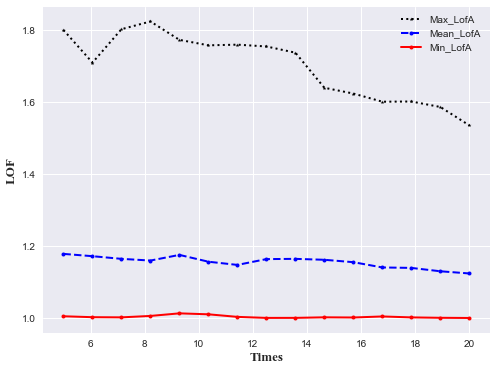

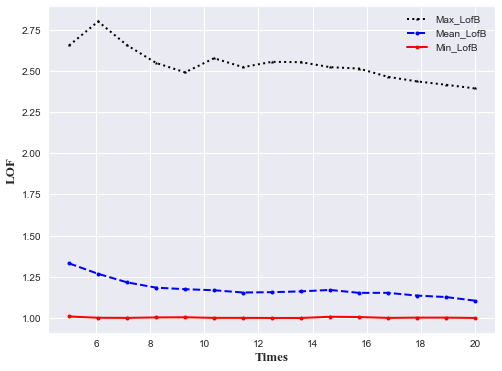

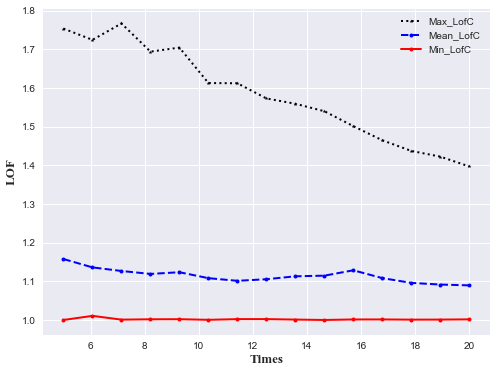

In [21]:

font = {'family':'Times new roman', 'weight':'normal', 'size': 13}  
plt.figure(figsize=(8, 6), facecolor='w')
ax = plt.subplot(1, 1, 1)
x_plot = np.linspace(5, 5+Count, Count)
ax.plot(x_plot, Max_lof_A, 'k*:', markersize=4, linewidth=2, label='Max_LofA')
ax.plot(x_plot, Mean_lof_A, 'bo--', markersize=4, linewidth=2, label='Mean_LofA')
ax.plot(x_plot, Min_lof_A, 'ro-', markersize=4, linewidth=2, label='Min_LofA')
plt.legend()
plt.xlabel("Times", fontdict=font)
plt.ylabel("LOF", fontdict=font)
plt.show()


plt.figure(figsize=(8, 6), facecolor='w')
ax = plt.subplot(1, 1, 1)
x_plot = np.linspace(5, 5+Count, Count)
ax.plot(x_plot, Max_lof_B, 'k*:', markersize=4, linewidth=2, label='Max_LofB')
ax.plot(x_plot, Mean_lof_B, 'bo--', markersize=4, linewidth=2, label='Mean_LofB')
ax.plot(x_plot, Min_lof_B, 'ro-', markersize=4, linewidth=2, label='Min_LofB')
plt.legend()
plt.xlabel("Times", fontdict=font)
plt.ylabel("LOF", fontdict=font)
plt.show()


plt.figure(figsize=(8, 6), facecolor='w')
ax = plt.subplot(1, 1, 1)
x_plot = np.linspace(5, 5+Count, Count)
ax.plot(x_plot, Max_lof_C, 'k*:', markersize=4, linewidth=2, label='Max_LofC')
ax.plot(x_plot, Mean_lof_C, 'bo--', markersize=4, linewidth=2, label='Mean_LofC')
ax.plot(x_plot, Min_lof_C, 'ro-', markersize=4, linewidth=2, label='Min_LofC')
plt.legend()
plt.xlabel("Times", fontdict=font)
plt.ylabel("LOF", fontdict=font)
plt.show()

In [5]:
# 对于Instane2二维数据,取9~12都可以
# 对Instane5五维数据
lof_A = outliers(8, Instane5_A)
lof_B = outliers(10, Instane5_B)
lof_C = outliers(7, Instane5_C)
# for outlier in lof:
# #     if outlier["lof"]>1.5:
#     print(outlier["lof"], outlier["instance"], outlier["index"])

In [6]:
# 建立序列与故障对应的权重值，用于权重LOF，与权重贝叶斯
# GrubbsList: 临界值，第一行为n=7,第二行为n=11，第一个数为0.95.第二个为0.99时的阈值
# Lof_Score为得分
import copy
GrubbsList = [[1.828, 1.938, 2.097], [2.088, 2.176, 2.410]] 
LinJieZhi = 0 #0代表0.90；1代表取0.95;1代表取0.99
# ================================================================
# Mean_Lof:求解每3组的LOF均值，用于判断是否为噪声点的条件
# Lof_Score：LOF得分原始输入，默认全部为1,返回对应的序列得分大小
# Instane5：输入为Instane5_A/B/C,用于计算大小
# lof为已经计算好的各省lof框架
# Fault：为输入原始数据，已经按照12行排列好
# LinJieZhi为临界值，控制Grubbs的阈值
# ================================================================
def Mean_Lof(Instane5, lof, Fault, LinJieZhi=0):
    Lof_Score = [1 for i in range(len(Instane5))]
    if len(Instane5)==132:
        MeanLof_Len = 11 #这里11需要根据省修改：取11或是7
        JJ = 1
    else:
        MeanLof_Len = 7
        JJ = 0
    #   序列得分赋值
    for outlier in lof:
        Lof_Score[outlier['index']] = outlier['lof']
    Lof_ScoreSort = [Lof_Score[i*12:(i+1)*12] for i in np.arange(MeanLof_Len)] 
    
    #     每三组得分均值计算与权重赋值
    Weight_matrix = copy.deepcopy(Lof_ScoreSort)
    Weight_matrix = np.array(Weight_matrix)
    Weight_matrix_T = Weight_matrix.T
    Mean_Lof = [0,0,0,0]
    Lof_ScoreSort = np.array(Lof_ScoreSort)
    Lof_ScoreSort_T = Lof_ScoreSort.T #转置一下，便于与均值作比较
    for i in range(4):
        Mean_Lof[i] = Lof_ScoreSort[:, (i*3):(3*(i+1))].sum()
        Mean_Lof[i] = Mean_Lof[i]/(3*MeanLof_Len)     #计算均值

        for j in range(3):
            A = Lof_ScoreSort_T[(i*3+j), :]   #定位到行
#             以下代码为确定Grubbs值
            Every_line = Fault.T[(i*3+j)]
#             print(Every_line*100)
            Mean_line = Every_line.mean() #计算均值
            Std_line = Every_line.std()   #计算标准差
#             以上代码为确定Grubbs值            
            for IP in range(MeanLof_Len):
                B = A[IP]                     #定位到列中具体数
                if B < Mean_Lof[i]:
                    Weight_matrix_T[(i*3+j), IP] = 1  #权值赋值
                else:
                    Z_Score = abs(Every_line[IP] - Mean_line)/Std_line
#                     print(Z_Score)
                    if Z_Score > GrubbsList[JJ][LinJieZhi]:
                        Weight_matrix_T[(i*3+j), IP] = np.exp(-B/4)   #权值赋值,这条语句还需要修改
                    else:
                        Weight_matrix_T[(i*3+j), IP] = 1  #权值赋值
                
    Weight_matrix = Weight_matrix_T.T
    
    return Mean_Lof, Lof_Score, Weight_matrix

Mean_Lof_A, Lof_Score_A, Weight_matrix_A = Mean_Lof(Instane5_A, lof_A, elec_faults_A, LinJieZhi)
Mean_Lof_B, Lof_Score_B, Weight_matrix_B = Mean_Lof(Instane5_B, lof_B, elec_faults2, LinJieZhi)
Mean_Lof_C, Lof_Score_C, Weight_matrix_C = Mean_Lof(Instane5_C, lof_C, elec_faults_C, LinJieZhi)

print(Mean_Lof_B)
# print(Lof_Score_B)
print(Weight_matrix_B)
# for i in Weight_matrix_B:
#     for j in i:
#         print(j)
# print(Weight_matrix_A)
# print(Weight_matrix_B)
# print(Weight_matrix_C)

[1.0225732240817926, 1.1027730092296781, 1.095960834069409, 1.1358845865469958]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [7]:
Weight_All = []
Weight_matrix_A = np.array(Weight_matrix_A)
Weight_matrix_B = np.array(Weight_matrix_B)
Weight_matrix_C = np.array(Weight_matrix_C)

a = Weight_matrix_A.flatten()
b = Weight_matrix_B.flatten()
c = Weight_matrix_C.flatten()
a_list=list(a)
b_list=list(b)
c_list=list(c)
a_list.extend(b_list)
a_list.extend(c_list)
print(len(a_list))

Weight_All = a_list
Weight_Fault_ABC_All = Weight_All*elec_faultsA
print(Weight_All)
print(elec_faultsA*100)
print(Weight_Fault_ABC_All*100)

np.savetxt('Weight_Fault_ABC_All.csv', Weight_Fault_ABC_All, delimiter = ',')

300
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7706934157067246, 1.0, 0.7532059303267398, 0.6337856836427641, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6684199501707766, 0.7100911843034757, 1.0, 1.0, 0.7185233545316557, 0.7208000487044122, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

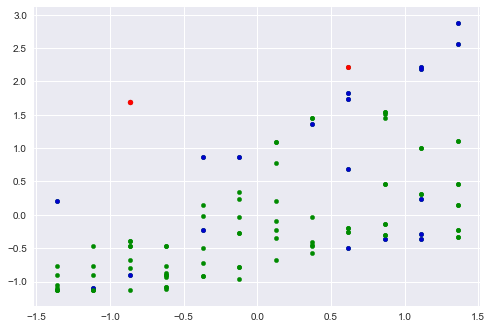

In [10]:
# lof = outliers(10, Instane5_A)

x, y = zip(*Instane2_C)
plt.scatter(y, x, s=20, color="#008B00")


for outlier in lof_C:
    value = outlier["lof"]
    instance = outlier["instance"]
    if value>1.1 and value<=1.5:
        color = "#0000CD" #蓝色
    elif value > 1.5:
        color = "#FF0000"  #红色
    else:
        color = "#008B00"  #绿色
    plt.scatter(instance[1], instance[0], color=color, s=(value-1)**2*10+20)
plt.show()

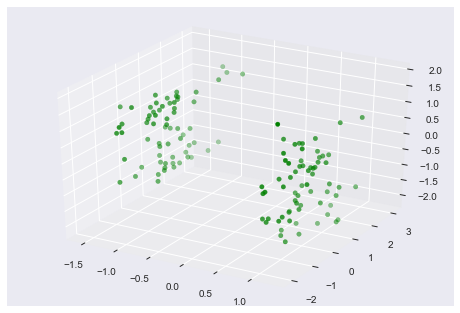

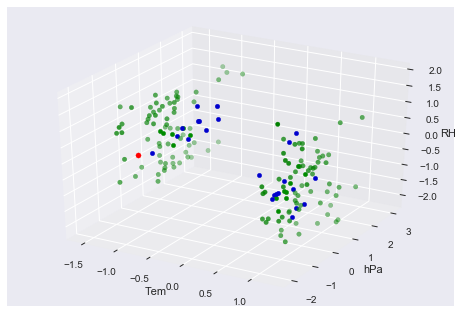

In [13]:
ax = plt.subplot(111, projection='3d')
ax.scatter(elec_RH1, elec_hPa1, elec_tem1, c='g')
plt.show()

ax = plt.subplot(111, projection='3d')
ax.scatter(elec_RH1, elec_hPa1, elec_tem1, c='g')
for outlier in lof_A:
    value = outlier["lof"]
    instance = outlier["instance"]
    
    if value>1.1 and value<=1.5:
        color = "#0000CD" #蓝色
    elif value > 1.5:
        color = "#FF0000"  #红色
    else:
        color = "#008B00"
    ax.scatter(instance[4], instance[3], instance[2],  c=color, s=(value-1)**2*10+20)
#     ax.scatter(instance[2], instance[1], instance[0],  c=color, s=(value-1)**2*10+20)
ax.set_zlabel('RH')  # 坐标轴
ax.set_ylabel('hPa')
ax.set_xlabel('Tem')
plt.show()

sklearn--Anomaly detection with Local Outlier Factor (LOF)
---

Grubbs异常点检测
---

In [10]:
print(elec_faults2*100)

# =====================================================================================
# GrubbsList: 临界值，第一行为n=7,第二行为n=11，第一个数为0.95.第二个为0.99时的阈值
# GrubbS：计算elec_faults2每列的Grubbs值
# 输入值：Fault：排列好的故障率数据，每个地点一组数据，每组长度为12。elec_faults2
# 返回值：
#     Index.append(Max_line[0])              #返回每一组哪个数据的索引值
#     ZSCORE.append(Z_Score)                 #返回具体得分
#     II.append(i)                           #返回第几组索引
#     Value.append(Every_line[Max_line[0]])  #返回异常值对应原始值
# =====================================================================================
GrubbsList = [[1.938, 2.097], [2.176, 2.410]] 
LinJieZhi = 0 #0代表0.95；1代表取0.99
def GrubbS(Fault, LinJieZhi=1):
    Index = []
    ZSCORE = []
    II = []
    Value = []
    for i in np.arange(len(Fault.T)):
        Every_line = Fault[:, i]
        Mean_line = Every_line.mean() #计算均值
        Std_line = Every_line.std()   #计算标准差

        Temp = abs(Every_line - Mean_line)
        Max_line = np.where(Temp==np.max(Temp)) #返回最大值的索引
        Max_line = Max_line[0]        #返回索引

        Z_Score = Temp[Max_line[0]]/Std_line
        if len(Every_line)==7:   #确定是哪个省的数据，用于选择GrubbsList的行号
            JJ = 0
        if len(Every_line)==11:
            JJ = 1
            
        if Z_Score > GrubbsList[JJ][LinJieZhi]: #默认取0.95
            Index.append(Max_line[0])              #返回每一组哪个数据的索引值
            ZSCORE.append(Z_Score)                 #返回具体得分
            II.append(i)                           #返回第几组索引
            Value.append(Every_line[Max_line[0]])  #返回异常值对应原始值
    return Index, ZSCORE, II, Value

Max_index, Z_score, Hang_index, Max_Value = GrubbS(elec_faults2)
print(Max_index)
print(Hang_index)
print(Z_score)
print(Max_Value)

[[ 0.  0.  4.  3.  3.  3.  6.  5.  8.  6. 10.  6.]
 [ 0.  0.  1.  1.  3.  2.  3.  3.  2.  2.  8.  6.]
 [ 0.  0.  2.  1.  6.  6.  2.  2.  3.  2. 14. 13.]
 [ 1.  1.  5.  4. 30. 26. 23. 19. 25. 22. 22. 18.]
 [ 1.  1.  2.  2.  5.  4.  6.  5.  5.  5. 19. 15.]
 [ 2.  3.  3.  2. 52. 43.  9.  6. 49. 46. 43. 31.]
 [ 0.  0.  0.  0.  1.  0.  8.  6.  4.  3.  5.  4.]
 [ 0.  0.  1.  0.  3.  2. 19. 14. 13. 13. 15. 19.]
 [ 1.  0.  3.  3. 12. 17. 39. 31. 15. 13.  9. 12.]
 [ 0.  0.  3.  3. 11.  9. 33. 23. 13. 10. 96. 69.]
 [ 0.  0.  1.  0.  2.  2. 24. 23. 14. 16. 10.  8.]]
[5, 5, 5, 5, 5, 5, 9, 9]
[0, 1, 4, 5, 8, 9, 10, 11]
[2.544994774935888, 3.025846415214352, 2.6926810640520915, 2.5484898846797073, 2.7297074141559166, 2.7461046979694137, 2.9076660547459365, 2.8809798445643353]
[0.015306903413439462, 0.030613806826878923, 0.5204347160569417, 0.42859329557630493, 0.4898209092300628, 0.45920710240318385, 0.9598244892362539, 0.6855889208830386]
